# Evaluation: Automated Unit Test Generation for Python

Provides the empirical evaluation for S. Lukasczyk, F. Kroiß, and G. Fraser.
*Automated Unit Test Generation for Python*.  Submitted to SSBSE 2020.

In [1]:
# Do all necessary imports here
import itertools as it
import statistics

from bisect import bisect_left
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylatex
import scipy.stats as ss
import seaborn as sns

from pandas import Categorical

## Useful Functions for Evaluation

Implement the Vargha and Delaney (Â12) effect size statistics,
taken from a [GitHub Gist](https://gist.github.com/jacksonpradolima/f9b19d65b7f16603c837024d5f8c8a65).

In [2]:
def vd_a(treatment: List[float], control: List[float]) -> Tuple[float, str]:
    """Compute Vargha and Delaney A index

    A. Vargha and H. D. Delaney.  A critique and improvement of the CL common language
    effect size statistics of McGraw and Wong.  Journal of Educational and Behavioral
    Statistics, 25(2):101-132, 2000.

    The formula to compute A has been transformed to minimise accuracy errors, see
    https://mtorchiano.wordpress.com/2014/05/19/effect-size-of-r-precision/

    :param treatment: a list of numbers
    :param control: a list of numbers
    :return: the value estimate and the magnitude
    """
    m = len(treatment)
    n = len(control)

    #if m != n:
    #    raise ValueError("Parameter lists must have equal lengths")

    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    # A = (r1/m - (m+1)/2)/n  # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula with better accuracy

    levels = [0.147, 0.33, 0.474]
    magnitudes = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitudes[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude

Filter a data frame for a list of columns

In [3]:
def filter_data_frame(data_frame: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    return pd.DataFrame(data_frame, columns=cols)

## Load Data from CSV Files

In [4]:
# The names of the columns we are interested in
cut = "TargetModule"
project_name = "ProjectName"
config = "ConfigurationId"
coverage = "Coverage"
seconds = [f"CoverageTimeline_T{i}" for i in range(1, 601)]
use_cols = [cut, project_name, config, coverage] + seconds

sns.set(style="whitegrid")

# How often every CUT was executed
runs = 30

# Adjust this path on your system if you want to rerun this sheet!
PAPER_EXPORT_PATH = Path("/Users/sl/repos/papers/python-whole-suite-mosa-paper")

results = pd.read_csv(Path("..") / "data" / "results.csv")
project_information = pd.read_csv(Path("..") / "data" / "projects.csv")

## Quick Overview

In [5]:
results.groupby(config)[coverage].describe()

,count,mean,std,min,25%,50%,75%,max
ConfigurationId,,,,,,,,
RandooPy-NoTypes,2748.0,0.621872,0.314282,0.037736,0.306122,0.647059,0.956522,1.0
RandooPy-TypeHintsInference,2270.0,0.630555,0.315175,0.037736,0.333333,0.666667,1.000000,1.0
WSPy-NoTypes,2465.0,0.675168,0.307157,0.037736,0.388889,0.750000,1.000000,1.0
WSPy-TypeHintsInference,2240.0,0.691693,0.305461,0.037736,0.409091,0.750000,1.000000,1.0


## Pre-Processing

In [6]:
number_cuts = len(set(results[cut]))
print(f"We tested {number_cuts} unique classes, each being executed {runs} times per configuration")

We tested 104 unique classes, each being executed 30 times per configuration


In [7]:
config_names = list(set(results[config]))
config_names.sort()
print("We used {} configurations, namely:\n - {}".format(
    len(config_names), "\n - ".join(config_names)
))

We used 4 configurations, namely:
 - RandooPy-NoTypes
 - RandooPy-TypeHintsInference
 - WSPy-NoTypes
 - WSPy-TypeHintsInference


In [8]:
randoopy_notypes = results[results[config] == "RandooPy-NoTypes"]
randoopy_typehints = results[results[config] == "RandooPy-TypeHintsInference"]
wspy_notypes = results[results[config] == "WSPy-NoTypes"]
wspy_typehints = results[results[config] == "WSPy-TypeHintsInference"]
configurations = [randoopy_notypes, randoopy_typehints, wspy_notypes, wspy_typehints]

In [9]:
konfigs = {}
for name in config_names:
    konfigs[name] = results[results[config] == name]

### Identifying Failing Runs and Crashes

In [10]:
data_points = {}
print("Available Data Points:")
print("----------------------")
for k in konfigs:
    l = len(set((konfigs[k])[cut]))
    data_points[k] = l
    s = " --> {:> 4} CUTS failed entirely".format(
        number_cuts - l
    ) if l != number_cuts else ""
    print("{: >30}: {: >4} / {} CUTS tested".format(k, l, number_cuts), s)

Available Data Points:
----------------------
              RandooPy-NoTypes:  100 / 104 CUTS tested  -->    4 CUTS failed entirely
   RandooPy-TypeHintsInference:   99 / 104 CUTS tested  -->    5 CUTS failed entirely
                  WSPy-NoTypes:  100 / 104 CUTS tested  -->    4 CUTS failed entirely
       WSPy-TypeHintsInference:   96 / 104 CUTS tested  -->    8 CUTS failed entirely


In [11]:
print("To mitigate the impact of stochastic anomalies, each CUT was tested multiple times.")
print(f"In detail, we executed each class {runs} times per configuration.")
if results.groupby([config, cut]).count().min().min() < runs:
    print("However, for certain classes the number of test runs is less.")
    print("Presumably, this is due to some crashes in Pynguin?")

To mitigate the impact of stochastic anomalies, each CUT was tested multiple times.
In detail, we executed each class 30 times per configuration.
However, for certain classes the number of test runs is less.
Presumably, this is due to some crashes in Pynguin?


In [12]:
print(f"Sanity check: Is there any CUT that was tested {runs} times?")
computed_runs = results.groupby([config, cut]).count().max().max()
if computed_runs == runs:
    print("YES :)")
else:
    print("NO!!!!!!!")

Sanity check: Is there any CUT that was tested 30 times?
YES :)


## RQ1: Whole-Suite Test Generation vs. Random Test Generation

In [13]:
ticks = list(set(results[project_name].values))
ticks.sort()

def set_box_colour(bp, colour):
    plt.setp(bp["boxes"], color=colour)
    plt.setp(bp["whiskers"], color=colour)
    plt.setp(bp["caps"], color=colour)
    plt.setp(bp["medians"], color=colour)

def get_result_lists(left_config: str, right_config: str) -> Tuple[List[pd.Series], List[pd.Series]]:
    bpl_dfs = []
    bpr_dfs = []
    for project in ticks:
        bpl_df = results[results[project_name] == project].groupby(config).get_group(
            left_config
        )["Coverage"]
        bpr_df = results[results[project_name] == project].groupby(config).get_group(
            right_config
        )["Coverage"]
        bpl_dfs.append(bpl_df)
        bpr_dfs.append(bpr_df)
    return bpl_dfs, bpr_dfs

/Users/sl/Library/Caches/pypoetry/virtualenvs/python-test-generation-experiments-hhYxqZzJ-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/sl/Library/Caches/pypoetry/virtualenvs/python-test-generation-experiments-hhYxqZzJ-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


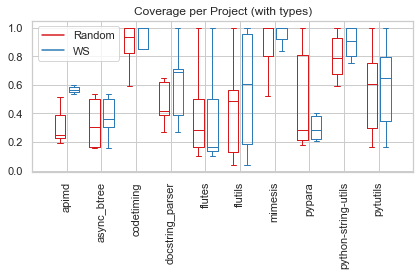

In [14]:
plt.figure()
plt.title("Coverage per Project (with types)")

bpl_dfs, bpr_dfs = get_result_lists("RandooPy-TypeHintsInference", "WSPy-TypeHintsInference")

bpl = plt.boxplot(
    bpl_dfs,
    positions=np.array(range(len(ticks))) * 2.0 - 0.4,
    sym="",
    widths=0.6,
)
bpr = plt.boxplot(
    bpr_dfs,
    positions=np.array(range(len(ticks))) * 2.0 + 0.4,
    sym="",
    widths=0.6,
)
set_box_colour(bpl, "#D7191C")
set_box_colour(bpr, "#2C7BB6")

plt.plot([], c="#D7191C", label="Random")
plt.plot([], c="#2C7BB6", label="WS")
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=90)
plt.xlim(-2, len(ticks) * 2)
plt.tight_layout()

plt.savefig(PAPER_EXPORT_PATH / "img" / "coverage-per-project-types.pdf", bbox_inches="tight")
plt.show()

/Users/sl/Library/Caches/pypoetry/virtualenvs/python-test-generation-experiments-hhYxqZzJ-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/sl/Library/Caches/pypoetry/virtualenvs/python-test-generation-experiments-hhYxqZzJ-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


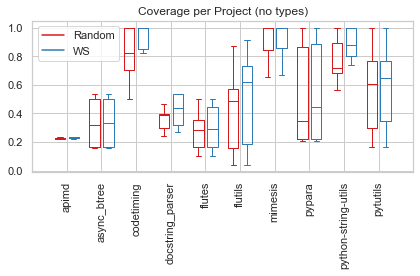

In [15]:
plt.figure()
plt.title("Coverage per Project (no types)")

bpl_dfs, bpr_dfs = get_result_lists("RandooPy-NoTypes", "WSPy-NoTypes")

bpl = plt.boxplot(
    bpl_dfs,
    positions=np.array(range(len(ticks))) * 2.0 - 0.4,
    sym="",
    widths=0.6,
)
bpr = plt.boxplot(
    bpr_dfs,
    positions=np.array(range(len(ticks))) * 2.0 + 0.4,
    sym="",
    widths=0.6,
)
set_box_colour(bpl, "#D7191C")
set_box_colour(bpr, "#2C7BB6")

plt.plot([], c="#D7191C", label="Random")
plt.plot([], c="#2C7BB6", label="WS")
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=90)
plt.xlim(-2, len(ticks) * 2)
plt.tight_layout()

plt.savefig(PAPER_EXPORT_PATH / "img" / "coverage-per-project-notypes.pdf", bbox_inches="tight")
plt.show()

In [16]:
def compute_data_for_effect_sizes(
    control_configuration: str,
    treatment_configuration: str,
) -> Dict[str, Dict[str, Tuple[List[float], List[float]]]]:
    data_per_project = {}
    for project in ticks:
        treatment = results[
            (results[config] == treatment_configuration)
            & (results[project_name] == project)
        ]
        control = results[
            (results[config] == control_configuration)
            & (results[project_name] == project)
        ]
        module_data = {}
        for module in set(control[cut].tolist()):
            control_values = control[
                control[cut] == module
            ][coverage].values.tolist()
            treatment_values = treatment[
                treatment[cut] == module
            ][coverage].values.tolist()
            if len(treatment_values) != len(control_values):
                z = min(len(control_values), len(treatment_values))
                control_values = control_values[:z]
                treatment_values = treatment_values[:z]
            module_data[module] = (control_values, treatment_values)
        data_per_project[project] = module_data
    return data_per_project


### Effect Sizes With Type Information

In [17]:
effect_sizes_for_latex = {}

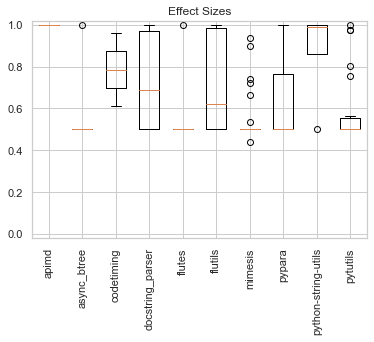

In [18]:
fig, ax = plt.subplots()
plt.title("Effect Sizes")
plt.xticks(rotation=90)
n = 0
effect_size_data = compute_data_for_effect_sizes("WSPy-TypeHintsInference", "RandooPy-TypeHintsInference")
for project, project_data in effect_size_data.items():
    effect_sizes = []
    for m, v in project_data.items():
        x, y = v
        try:
            effect_size, _ = vd_a(x, y)
            effect_sizes.append(effect_size)
        except ZeroDivisionError:
            pass
    ax.boxplot(effect_sizes, positions=[n], widths=0.6)
    n += 1
ax.set_xticks(range(len(ticks)))
ax.set_xticklabels(ticks)
ax.set_ylim(-0.02, 1.02)
plt.savefig(PAPER_EXPORT_PATH / "img" / "effect-sizes-typehints.pdf", bbox_inches="tight")
plt.show()

In [19]:
effect_sizes_per_project = {}
mann_whitney_values = {}
for project, project_data in effect_size_data.items():
    controls = []
    treatments = []
    for _, v in project_data.items():
        x, y = v
        controls.extend(x)
        treatments.extend(y)
    effect_sizes_per_project[project] = vd_a(controls, treatments)
    mann_whitney_values[project] = ss.mannwhitneyu(controls, treatments).pvalue

effect_sizes_for_latex["typehints"] = {}

for project, effect_size in effect_sizes_per_project.items():
    p_value = mann_whitney_values[project]
    is_significant = "(significant)" if p_value < 0.05 else ""
    print(f"Project {project}")
    print(f"    A12:     {effect_size[0]} ({effect_size[1]})")
    print(f"    p-value: {p_value} {is_significant}")
    print()
    effect_sizes_for_latex["typehints"][project] = {
        "a12": float(effect_size[0]),
        "effect": effect_size[1],
        "p_value": p_value,
    }

Project apimd
    A12:     1.0 (large)
    p-value: 1.5613030734324958e-07 (significant)

Project async_btree
    A12:     0.5345604808414726 (negligible)
    p-value: 0.1734152074610516 

Project codetiming
    A12:     0.6362795857988166 (small)
    p-value: 0.005313020883379603 (significant)

Project docstring_parser
    A12:     0.583838307802326 (small)
    p-value: 0.0041387876617775135 (significant)

Project flutes
    A12:     0.5056586690810322 (negligible)
    p-value: 0.4633153285068929 

Project flutils
    A12:     0.5411539485268524 (negligible)
    p-value: 0.06665285602141557 

Project mimesis
    A12:     0.5298047899306567 (negligible)
    p-value: 0.01728274383604878 (significant)

Project pypara
    A12:     0.6164933837429112 (small)
    p-value: 0.002859166702619572 (significant)

Project python-string-utils
    A12:     0.704952741020794 (medium)
    p-value: 2.9473880668246187e-08 (significant)

Project pytutils
    A12:     0.5250568819099504 (negligible)
    p

### Effect Sizes Without Type Information

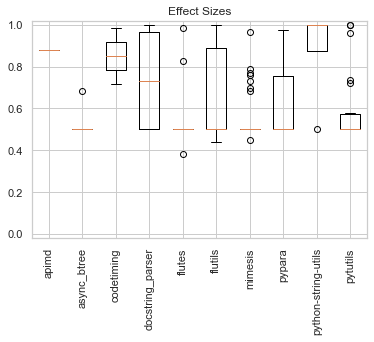

In [20]:
fig, ax = plt.subplots()
plt.title("Effect Sizes")
plt.xticks(rotation=90)
n = 0
effect_size_data = compute_data_for_effect_sizes("WSPy-NoTypes", "RandooPy-NoTypes")
for project, project_data in effect_size_data.items():
    effect_sizes = []
    for m, v in project_data.items():
        x, y = v
        try:
            effect_size, _ = vd_a(x, y)
            effect_sizes.append(effect_size)
        except ZeroDivisionError:
            pass
    ax.boxplot(effect_sizes, positions=[n], widths=0.6)
    n += 1
ax.set_xticks(range(len(ticks)))
ax.set_xticklabels(ticks)
ax.set_ylim(-0.02, 1.02)
plt.savefig(PAPER_EXPORT_PATH / "img" / "effect-sizes-notypes.pdf", bbox_inches="tight")
plt.show()

In [21]:
effect_sizes_per_project = {}
mann_whitney_values = {}
for project, project_data in effect_size_data.items():
    controls = []
    treatments = []
    for _, v in project_data.items():
        x, y = v
        controls.extend(x)
        treatments.extend(y)
    effect_sizes_per_project[project] = vd_a(controls, treatments)
    mann_whitney_values[project] = ss.mannwhitneyu(controls, treatments).pvalue

effect_sizes_for_latex["notypes"] = {}

for project, effect_size in effect_sizes_per_project.items():
    p_value = mann_whitney_values[project]
    is_significant = "(significant)" if p_value < 0.05 else ""
    print(f"Project {project}")
    print(f"    A12:     {effect_size[0]} ({effect_size[1]})")
    print(f"    p-value: {p_value} {is_significant}")
    print()
    effect_sizes_for_latex["notypes"][project] = {
        "a12": float(effect_size[0]),
        "effect": effect_size[1],
        "p_value": p_value,
    }

Project apimd
    A12:     0.8787158145065398 (large)
    p-value: 7.67993407165234e-08 (significant)

Project async_btree
    A12:     0.506 (negligible)
    p-value: 0.42787389198924486 

Project codetiming
    A12:     0.6753826530612245 (medium)
    p-value: 0.0004281534561123187 (significant)

Project docstring_parser
    A12:     0.58513863758619 (small)
    p-value: 0.00584010241461645 (significant)

Project flutes
    A12:     0.5198961937716263 (negligible)
    p-value: 0.34425599792278216 

Project flutils
    A12:     0.5567759401871256 (negligible)
    p-value: 0.011427130890927593 (significant)

Project mimesis
    A12:     0.5242688187046519 (negligible)
    p-value: 0.029318246498956098 (significant)

Project pypara
    A12:     0.5247992266508031 (negligible)
    p-value: 0.21639314315401215 

Project python-string-utils
    A12:     0.7280985238885492 (medium)
    p-value: 2.747265227295758e-09 (significant)

Project pytutils
    A12:     0.5262945173238961 (negligible

## RQ2: Influence of Type Information

In [22]:
def plot_coverage_for(c, config):
    data = config[config[cut] == c][seconds]
    if data["10"].min() < 1.0:
        data.aggregate(["min", "max", "mean"]).transpose().plot(
            title=c, yticks=np.arrange(0.0, 1.0, 0.1)
        )


def plot_configuration(config):
    for c in set(config[cut]):
        plot_coverage_for(c, config)


all_classes = set(results[cut])


def stupid_classes(config):
    classes = set()
    for c in all_classes:
        if (
            config[config[cut] == c]["CoverageTimeline_T600"].mean() -
                config[config[cut] == c]["CoverageTimeline_T1"].mean() < 0.01
        ):
            classes.add(c)
    return classes


def get_all_stupid_classes():
    d = {}
    for name, konfig in konfigs.items():
        d[name] = stupid_classes(konfig)
    return d


all_stupid_classes = get_all_stupid_classes()

In [23]:
print("Number of stupid classes:")
print("-------------------------")
print("We call a class “stupid” if the achieved coverage does not change over time")
print("Most of the time the reason is that we were not able to generate tests for those classes, thus the achieved coverage is only import coverage")

for k, cs in all_stupid_classes.items():
    cnt = len(cs)
    print("{: >30}   {}".format(k, cnt))

Number of stupid classes:
-------------------------
We call a class “stupid” if the achieved coverage does not change over time
Most of the time the reason is that we were not able to generate tests for those classes, thus the achieved coverage is only import coverage
              RandooPy-NoTypes   44
   RandooPy-TypeHintsInference   39
                  WSPy-NoTypes   58
       WSPy-TypeHintsInference   55


In [24]:
common_non_stupid_classes = all_classes
for k in all_stupid_classes:
    common_non_stupid_classes = common_non_stupid_classes.difference(
        all_stupid_classes[k]
    )

print(len(common_non_stupid_classes))

40


In [25]:
print(f"Number of modules: {len(all_classes)}")

Number of modules: 104


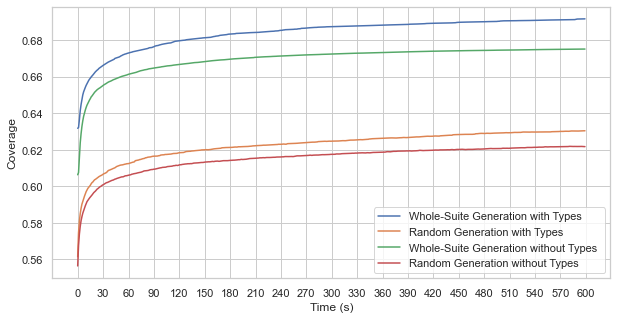

In [26]:
toplot = {}
legends = [
    "Whole-Suite Generation with Types ",
    "Random Generation with Types",
    "Whole-Suite Generation without Types ",
    "Random Generation without Types"
]
for k, cfg in enumerate([
    wspy_typehints, randoopy_typehints, wspy_notypes, randoopy_notypes
]):
    toplot[legends[k]] = (cfg[
        cfg[cut].isin(all_classes)
    ][seconds].mean())
fig, ax = plt.subplots()
pd.DataFrame(toplot).plot(ax=ax, figsize=(10, 5))
ax.set_xticks(range(0, 601, 30))
ax.set_xticklabels([i for i in range(0, 601, 30)])
# ax.set_ylim(0.0, 1.0)
ax.set_ylabel("Coverage")
ax.set_xlabel("Time (s)")
plt.savefig(PAPER_EXPORT_PATH / "img" / "coverage-over-time.pdf", bbox_inches="tight")
plt.show()

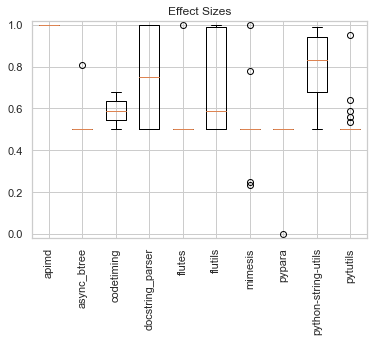

In [27]:
fig, ax = plt.subplots()
plt.title("Effect Sizes")
plt.xticks(rotation=90)
n = 0
effect_size_data = compute_data_for_effect_sizes("WSPy-TypeHintsInference", "WSPy-NoTypes")
for project, project_data in effect_size_data.items():
    effect_sizes = []
    for m, v in project_data.items():
        x, y = v
        try:
            effect_size, _ = vd_a(x, y)
            effect_sizes.append(effect_size)
        except ZeroDivisionError:
            pass
    ax.boxplot(effect_sizes, positions=[n], widths=0.6)
    n += 1
ax.set_xticks(range(len(ticks)))
ax.set_xticklabels(ticks)
ax.set_ylim(-0.02, 1.02)
plt.savefig(PAPER_EXPORT_PATH / "img" / "effect-sizes-ws.pdf", bbox_inches="tight")
plt.show()

In [28]:
effect_sizes_per_project = {}
mann_whitney_values = {}
for project, project_data in effect_size_data.items():
    controls = []
    treatments = []
    for _, v in project_data.items():
        x, y = v
        controls.extend(x)
        treatments.extend(y)
    effect_sizes_per_project[project] = vd_a(controls, treatments)
    mann_whitney_values[project] = ss.mannwhitneyu(controls, treatments).pvalue

effect_sizes_for_latex["ws"] = {}

for project, effect_size in effect_sizes_per_project.items():
    p_value = mann_whitney_values[project]
    is_significant = "(significant)" if p_value < 0.05 else ""
    print(f"Project {project}")
    print(f"    A12:     {effect_size[0]} ({effect_size[1]})")
    print(f"    p-value: {p_value} {is_significant}")
    print()
    effect_sizes_for_latex["ws"][project] = {
        "a12": float(effect_size[0]),
        "effect": effect_size[1],
        "p_value": p_value,
    }

Project apimd
    A12:     1.0 (large)
    p-value: 1.0885423221066458e-07 (significant)

Project async_btree
    A12:     0.5142066798715935 (negligible)
    p-value: 0.3495523172171148 

Project codetiming
    A12:     0.5416050295857988 (negligible)
    p-value: 0.20753332540789243 

Project docstring_parser
    A12:     0.5693314818488395 (negligible)
    p-value: 0.020385561300943076 (significant)

Project flutes
    A12:     0.5067604110329909 (negligible)
    p-value: 0.45820527941050065 

Project flutils
    A12:     0.5413301094696568 (negligible)
    p-value: 0.07876754556012305 

Project mimesis
    A12:     0.5132803962547898 (negligible)
    p-value: 0.15525674215720364 

Project pypara
    A12:     0.47692729766803843 (negligible)
    p-value: 0.2526061984923983 

Project python-string-utils
    A12:     0.6105773429993886 (small)
    p-value: 0.002295509821771542 (significant)

Project pytutils
    A12:     0.5042126498160674 (negligible)
    p-value: 0.3968568800274816 

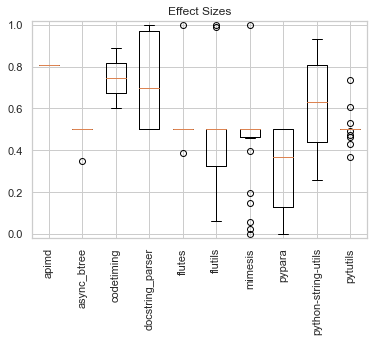

In [29]:
fig, ax = plt.subplots()
plt.title("Effect Sizes")
plt.xticks(rotation=90)
n = 0
effect_size_data = compute_data_for_effect_sizes("RandooPy-TypeHintsInference", "RandooPy-NoTypes")
for project, project_data in effect_size_data.items():
    effect_sizes = []
    for m, v in project_data.items():
        x, y = v
        try:
            effect_size, _ = vd_a(x, y)
            effect_sizes.append(effect_size)
        except ZeroDivisionError:
            pass
    ax.boxplot(effect_sizes, positions=[n], widths=0.6)
    n += 1
ax.set_xticks(range(len(ticks)))
ax.set_xticklabels(ticks)
ax.set_ylim(-0.02, 1.02)
plt.savefig(PAPER_EXPORT_PATH / "img" / "effect-sizes-random.pdf", bbox_inches="tight")
plt.show()

In [30]:
effect_sizes_per_project = {}
mann_whitney_values = {}
for project, project_data in effect_size_data.items():
    controls = []
    treatments = []
    for _, v in project_data.items():
        x, y = v
        controls.extend(x)
        treatments.extend(y)
    effect_sizes_per_project[project] = vd_a(controls, treatments)
    mann_whitney_values[project] = ss.mannwhitneyu(controls, treatments).pvalue

effect_sizes_for_latex["random"] = {}

for project, effect_size in effect_sizes_per_project.items():
    p_value = mann_whitney_values[project]
    is_significant = "(significant)" if p_value < 0.05 else ""
    print(f"Project {project}")
    print(f"    A12:     {effect_size[0]} ({effect_size[1]})")
    print(f"    p-value: {p_value} {is_significant}")
    print()
    effect_sizes_for_latex["random"][project] = {
        "a12": float(effect_size[0]),
        "effect": effect_size[1],
        "p_value": p_value,
    }

Project apimd
    A12:     0.8088888888888889 (large)
    p-value: 1.461481522349877e-05 (significant)

Project async_btree
    A12:     0.4875 (negligible)
    p-value: 0.33901661094526997 

Project codetiming
    A12:     0.6285550129273197 (small)
    p-value: 0.006611491865095002 (significant)

Project docstring_parser
    A12:     0.6335185185185185 (small)
    p-value: 5.04726058109523e-06 (significant)

Project flutes
    A12:     0.5109164033323758 (negligible)
    p-value: 0.41935269652542506 

Project flutils
    A12:     0.501093642688644 (negligible)
    p-value: 0.47961035187843687 

Project mimesis
    A12:     0.4884218879579056 (negligible)
    p-value: 0.19874812476073384 

Project pypara
    A12:     0.41058787319175133 (small)
    p-value: 0.009371511338051804 (significant)

Project python-string-utils
    A12:     0.5701917360285375 (negligible)
    p-value: 0.031307449784556664 (significant)

Project pytutils
    A12:     0.5043775036051915 (negligible)
    p-value

## LaTeX Macros

In [31]:
plt.savefig(PAPER_EXPORT_PATH / "img" / "coverage-per-project.pdf", bbox_inches="tight")
with open(PAPER_EXPORT_PATH / "macros.tex", mode="w") as f:
    f.write("\\newcommand{\\numIterations}{" + str(runs) + "}\n")
    f.write("\\newcommand{\\numProjects}{" + str(len(ticks)) + "}\n")
    f.write("\\newcommand{\\numUniqueClasses}{" + str(number_cuts) + "}\n")
    f.write("\n")
    for cn, cr in konfigs.items():
        macro_config_name = str(cn.replace("-", ""))
        macro_name = f"AvgCov{macro_config_name}"
        value = str(float(cr[coverage].mean() * 100))
        content = "\\newcommand{\\" + macro_name + "}{" + value + "}"
        print(content)
        f.write(content + "\n")

    print()
    f.write("\n")

    for c, dat in effect_sizes_for_latex.items():
        a12_values = []
        for proj_name, eff_data in dat.items():
            macro_project_name  = proj_name.replace("-", "").replace("_", "")
            a12_values.append(float(eff_data["a12"]))
            macro_name_basis = f"EffSize{c}{macro_project_name}"
            a12_macro = "\\newcommand{\\" + macro_name_basis + "A}{" + str(eff_data["a12"]) + "}"
            effect_macro = "\\newcommand{\\" + macro_name_basis + "Eff}{" + eff_data["effect"] + "}"
            p_macro = "\\newcommand{\\" + macro_name_basis + "Pvalue}{" + str(eff_data["p_value"]) + "}"
            print(a12_macro)
            print(effect_macro)
            print(p_macro)
            print()
            f.write(a12_macro + "\n")
            f.write(effect_macro + "\n")
            f.write(p_macro + "\n")
            f.write("\n")
        a12_avg_macro = "\\newcommand{\\AvgEffSize" + c + "}{" + str(statistics.mean(a12_values)) + "}"
        print(a12_avg_macro)
        f.write(a12_avg_macro + "\n")
        print()
        f.write("\n")

\newcommand{\AvgCovRandooPyNoTypes}{62.18722257865684}
\newcommand{\AvgCovRandooPyTypeHintsInference}{63.05549138535335}
\newcommand{\AvgCovWSPyNoTypes}{67.5168191227787}
\newcommand{\AvgCovWSPyTypeHintsInference}{69.16931311126037}

\newcommand{\EffSizetypehintsapimdA}{1.0}
\newcommand{\EffSizetypehintsapimdEff}{large}
\newcommand{\EffSizetypehintsapimdPvalue}{1.5613030734324958e-07}

\newcommand{\EffSizetypehintsasyncbtreeA}{0.5345604808414726}
\newcommand{\EffSizetypehintsasyncbtreeEff}{negligible}
\newcommand{\EffSizetypehintsasyncbtreePvalue}{0.1734152074610516}

\newcommand{\EffSizetypehintscodetimingA}{0.6362795857988166}
\newcommand{\EffSizetypehintscodetimingEff}{small}
\newcommand{\EffSizetypehintscodetimingPvalue}{0.005313020883379603}

\newcommand{\EffSizetypehintsdocstringparserA}{0.583838307802326}
\newcommand{\EffSizetypehintsdocstringparserEff}{small}
\newcommand{\EffSizetypehintsdocstringparserPvalue}{0.0041387876617775135}

\newcommand{\EffSizetypehintsflutesA}{0.5056

<Figure size 432x288 with 0 Axes>

### Project Overview Table

In [32]:
table = pylatex.Tabular("l r r r r r r", booktabs=True)
table.add_row([
    "Project Name",
    "Version",
    "Lines of Code",
    "Used Modules",
    "Avg. # Code Objects",
    "Avg. # Predicates",
    "Avg. # Types",
])

considered_cuts = set(results[cut])
considered_projects = project_information[project_information["filename"].isin(considered_cuts)]

raw_table_data = considered_projects.groupby(["project", "version"], as_index=False).agg(
    {
        "code": "sum",
        "filename": "count",
        "CodeObjects": "mean",
        "Predicates": "mean",
        "GenerableTypes": "mean",
        "num_parameter_types": "mean",
    }
)
locs = 0
modules_count = 0
code_objects = []
predicates = []
accessibles = []
generable_types = []
parameter_types = []
for _, row in raw_table_data.iterrows():
    table.add_row([
        pylatex.utils.verbatim(row["project"]),
        row["version"],
        row["code"],
        row["filename"],
        row["CodeObjects"],
        row["Predicates"],
        row["GenerableTypes"],
    ])
    locs += int(row["code"])
    modules_count += int(row["filename"])
    code_objects.append(float(row["CodeObjects"]))
    predicates.append(float(row["Predicates"]))
    generable_types.append(float(row["GenerableTypes"]))
    parameter_types.append(float(row["num_parameter_types"]))

table.add_hline()
table.add_row([
    "Total",
    "",
    locs,
    modules_count,
    sum(code_objects),
    sum(predicates),
    sum(generable_types),
])

print(table.dumps())

\begin{tabular}{@{}l r r r r r r@{}}%
\toprule%
Project Name&Version&Lines of Code&Used Modules&Avg. \# Code Objects&Avg. \# Predicates&Avg. \# Types\\%
\verb|apimd|&1.0.2&316&1&35.0&83.0&11.0\\%
\verb|async_btree|&1.0.1&284&6&9.0&8.666666666666666&6.333333333333333\\%
\verb|codetiming|&1.2.0&85&2&18.0&8.0&6.0\\%
\verb|docstring_parser|&0.7.1&608&6&12.0&15.666666666666666&9.5\\%
\verb|flutes|&0.2.0.post0&1085&9&19.0&26.0&5.0\\%
\verb|flutils|&0.6&1715&13&10.23076923076923&22.307692307692307&8.384615384615385\\%
\verb|mimesis|&4.0.0&1663&34&12.333333333333334&5.7&9.166666666666666\\%
\verb|pypara|&0.0.22&1305&6&47.166666666666664&23.5&12.0\\%
\verb|python-string-utils|&1.0.0&476&4&21.0&29.5&6.5\\%
\verb|pytutils|&0.4.1&1108&23&8.1875&6.625&6.0625\\%
\midrule%
Total&&8645&104&191.91826923076923&228.96602564102562&79.94711538461539\\\bottomrule%
%
\end{tabular}
